# Machine Learning Engineer Nanodegree Capstone Project

## Bitcoin Price Prediction

This project is to use historic bitcoin price data to train up a model to predict whether the bitcoin price on the next day will go up or down.

## 1. Data Exploration

### 1.1 Loading Libraries and Data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from pandas.plotting._misc import autocorrelation_plot
from stockstats import StockDataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from time import time
import warnings
import logging

pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

In [2]:
data_file = 'data/bitstampUSD_1-min_data_2012-01-01_to_2019-08-12.csv'

def parser(x):
    """
    Parse timestamp to datetime string
    Parameters:
    x - the timestamp to be parsed
    Returns:
    the datetime string in 'Y-m-d H:M:S' format
    """
    ts = int(x)
    return datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

data = pd.read_csv(data_file, header=0, parse_dates=[0], date_parser=parser)

### 1.2 Display Data Sample

In [3]:
display(data.head(10))

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2011-12-31 07:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2011-12-31 07:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2011-12-31 07:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2011-12-31 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2011-12-31 08:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data['Date'] = data['Timestamp'].dt.date
data = data.dropna()

In [5]:
# group data by date
data_grouped = data.groupby('Date')

Calculate Open, High, Low, Close prices of the bitcoin and also the transaction volume on each day

In [6]:
openp = data_grouped['Open'].first()
close = data_grouped['Close'].last()
high = data_grouped['High'].max()
low = data_grouped['Low'].min()
volume = data_grouped['Volume_(BTC)'].sum()
date = data_grouped['Date'].first()

### 1.3 Data Visualization

Visualize the trend of the close price of bitcoin from Jan 2012 to Aug 2019

Text(0, 0.5, 'Price')

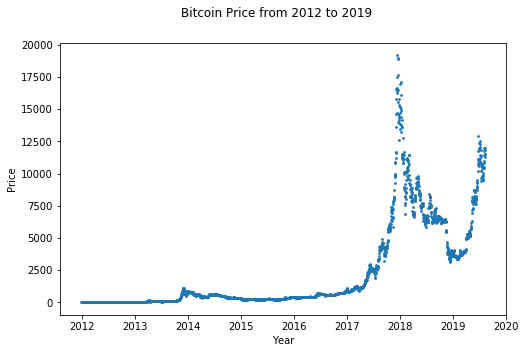

In [7]:
register_matplotlib_converters()

plt.figure(figsize=(8,5))
plt.scatter(date, close, s=3)
plt.suptitle('Bitcoin Price from 2012 to 2019')
plt.xlabel('Year')
plt.ylabel('Price')

### 1.4 Load OHLC bitcoin prices and transaction volume on each day into a dataframe

In [8]:
final_data = pd.concat([openp, high, low, volume, close], axis=1)
final_data = final_data.iloc[1:-1].reset_index(drop=True)
final_data = final_data.rename(columns={"Open":"open","High":"high","Low":"low","Volume_(BTC)":"volume","Close":"close"})
print(final_data)

          open      high       low        volume     close
0         4.58      5.00      4.58     21.602000      5.00
1         5.00      5.00      5.00     19.048000      5.00
2         5.32      5.32      5.14     88.037281      5.29
3         4.93      5.57      4.93    107.233260      5.57
4         5.72      6.65      5.72     94.801829      6.65
...        ...       ...       ...           ...       ...
2772  11471.58  12145.42  11388.01  15480.455242  11971.57
2773  11973.46  12061.10  11450.93  10144.462109  11983.43
2774  11985.60  12040.00  11650.00   7336.914849  11859.32
2775  11859.32  11976.68  11200.00   7447.248341  11273.20
2776  11273.03  11589.73  11080.37   4361.390692  11528.73

[2777 rows x 5 columns]


## 2. Feature Engineering

Based on the OHLC prices and volume, we build some technical indicators: exponential moving average, relative strength index, stochastic oscillator, and moving average convergence divergence.

In [9]:
stock_df = StockDataFrame.retype(final_data)

# exponential moving average
final_data['ema'] = stock_df['close_5_ema']
del final_data['close_5_ema']

# relative strength index
final_data['rsi'] = stock_df['rsi_12']
del final_data['rs_12']
del final_data['rsi_12']
del final_data['close_-1_s']
del final_data['close_-1_d']
del final_data['closepm']
del final_data['closenm']
del final_data['closenm_12_smma']
del final_data['closepm_12_smma']

# stochastic oscillator
final_data['kdjk'] = stock_df['kdjk']
final_data['kdjd'] = stock_df['kdjd']
final_data['kdjj'] = stock_df['kdjj']

# moving average convergence divergence
final_data['macd'] = stock_df['macd']
print(final_data)

NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


          open      high       low        volume     close           ema  \
0         4.58      5.00      4.58     21.602000      5.00      5.000000   
1         5.00      5.00      5.00     19.048000      5.00      5.000000   
2         5.32      5.32      5.14     88.037281      5.29      5.137368   
3         4.93      5.57      4.93    107.233260      5.57      5.317077   
4         5.72      6.65      5.72     94.801829      6.65      5.828768   
...        ...       ...       ...           ...       ...           ...   
2772  11471.58  12145.42  11388.01  15480.455242  11971.57  11424.328793   
2773  11973.46  12061.10  11450.93  10144.462109  11983.43  11610.695862   
2774  11985.60  12040.00  11650.00   7336.914849  11859.32  11693.570575   
2775  11859.32  11976.68  11200.00   7447.248341  11273.20  11553.447050   
2776  11273.03  11589.73  11080.37   4361.390692  11528.73  11545.208033   

             rsi       kdjk       kdjd        kdjj        macd  
0            NaN  66.6

In [10]:
final_data.corr()

,open,high,low,volume,close,ema,rsi,kdjk,kdjd,kdjj,macd
open,1.000000,0.999000,0.998138,0.103512,0.997965,0.999042,-0.042072,-0.053540,-0.052841,-0.044799,0.299219
high,0.999000,1.000000,0.997958,0.110062,0.999183,0.998879,-0.035283,-0.049982,-0.050406,-0.040496,0.304526
low,0.998138,0.997958,1.000000,0.088722,0.998814,0.997902,-0.035465,-0.048158,-0.051534,-0.035362,0.294764
volume,0.103512,0.110062,0.088722,1.000000,0.100586,0.104903,-0.070175,-0.092784,-0.064413,-0.111096,0.043586
close,0.997965,0.999183,0.998814,0.100586,1.000000,0.998325,-0.030313,-0.045501,-0.048794,-0.033283,0.304261
ema,0.999042,0.998879,0.997902,0.104903,0.998325,1.000000,-0.050744,-0.064933,-0.063061,-0.055595,0.286289
rsi,-0.042072,-0.035283,-0.035465,-0.070175,-0.030313,-0.050744,1.000000,0.810679,0.814283,0.660986,0.364074
kdjk,-0.053540,-0.049982,-0.048158,-0.092784,-0.045501,-0.064933,0.810679,1.000000,0.935440,0.900200,0.278224
kdjd,-0.052841,-0.050406,-0.051534,-0.064413,-0.048794,-0.063061,0.814283,0.935440,1.000000,0.688150,0.340350
kdjj,-0.044799,-0.040496,-0.035362,-0.111096,-0.033283,-0.055595,0.660986,0.900200,0.688150,1.000000,0.151794


We select which technical indicators to use based on their correlations. Remove exponential moving average which is highly correlated with the OHLC prices. Remove KDJK and KDJD which are correlated with KDJJ, and they are more correlated with moving average convergence divergence than KDJJ.

In [11]:
del final_data['ema']
del final_data['kdjk']
del final_data['kdjd']
final_data = final_data.dropna().reset_index(drop=True)
print(final_data)

          open      high       low        volume     close         rsi  \
0         5.32      5.32      5.14     88.037281      5.29  100.000000   
1         4.93      5.57      4.93    107.233260      5.57  100.000000   
2         5.72      6.65      5.72     94.801829      6.65  100.000000   
3         6.65      6.90      6.00     33.882747      6.00   69.027732   
4         6.80      6.80      6.80      0.295858      6.80   78.124634   
...        ...       ...       ...           ...       ...         ...   
2770  11471.58  12145.42  11388.01  15480.455242  11971.57   66.509764   
2771  11973.46  12061.10  11450.93  10144.462109  11983.43   66.609543   
2772  11985.60  12040.00  11650.00   7336.914849  11859.32   64.418529   
2773  11859.32  11976.68  11200.00   7447.248341  11273.20   55.083811   
2774  11273.03  11589.73  11080.37   4361.390692  11528.73   57.979772   

            kdjj        macd  
0     111.661662    0.008993  
1     114.959404    0.022972  
2     114.762911  

## 3. Data Preprocessing

### 3.1 Data Labeling

We label the record as 1 while the close price of the next day go up, and as 0 when the price go down on the next day.

In [12]:
up_down = []

close_data = final_data['close']

for i, price in close_data.items():
    if i + 1 < close_data.size:
        if close_data.iloc[i+1] > price:
            up_down.append(1)
        else:
            up_down.append(0)

final_data = final_data.iloc[:-1]
labels = pd.Series(np.array(up_down))

### 3.2 Log Transformation

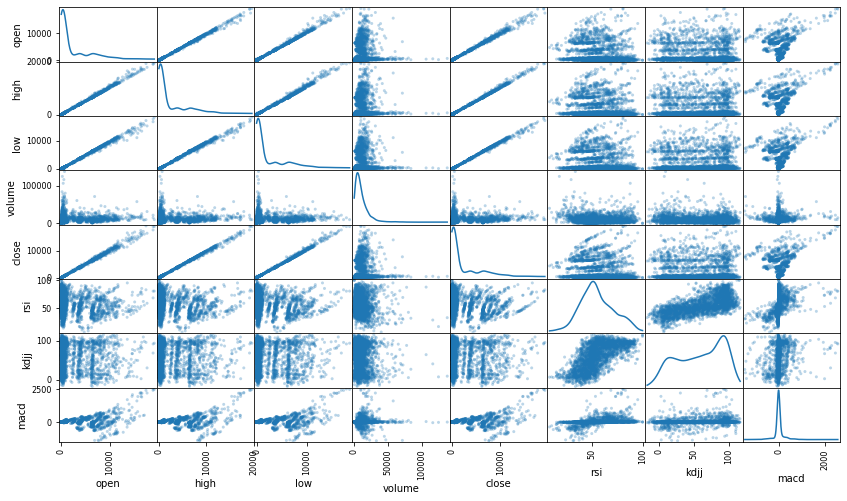

In [13]:
pd.plotting.scatter_matrix(final_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

Apply log transformation to the 'open', 'high', 'low', 'volume', and 'close' features as they are right-skewed. 

In [14]:
skewed = ['open','high','low','volume','close']
final_data_transformed = pd.DataFrame(data=final_data)
final_data_transformed[skewed] = final_data[skewed].apply(lambda x: np.log(x+1))

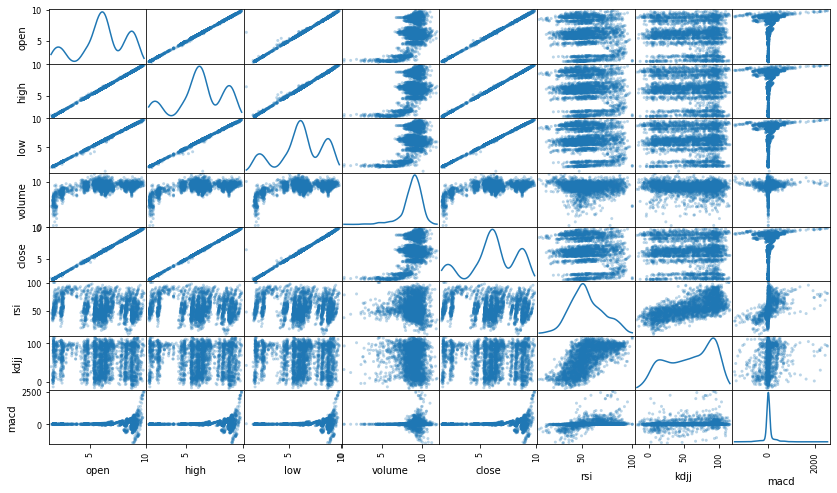

In [15]:
pd.plotting.scatter_matrix(final_data_transformed, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### 3.3 Min-Max Scaling

We apply scaling to all the features. Normalization ensures that each feature is treated equally when applying supervised learners.

In [16]:
scaler = MinMaxScaler() 

final_data_minmax_transformed = scaler.fit_transform(final_data_transformed)

print(final_data_minmax_transformed)

[[0.03317109 0.01962831 0.10087505 ... 1.         0.9651478  0.36246275]
 [0.02549095 0.02435705 0.09696813 ... 1.         0.98992334 0.36246627]
 [0.04057077 0.04290796 0.11100859 ... 1.         0.98844711 0.36247885]
 ...
 [0.94314202 0.94041038 0.94636222 ... 0.63631149 0.82286884 0.44415794]
 [0.9432642  0.94019697 0.94829699 ... 0.61244697 0.77913098 0.45421541]
 [0.94198717 0.93955429 0.94387494 ... 0.51077333 0.55964415 0.44930099]]


### 3.4 Data Splitting

We use the first 84% of data as the training set. The following 8% of data treats as the validation set. The last 8% acts as the testing set.

In [17]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(final_data_minmax_transformed, 
                                                    labels, 
                                                    test_size = 0.08, 
                                                    random_state = 0,
                                                    shuffle = False)

X_train, X_valid_test, y_train, y_valid_test = train_test_split(final_data_minmax_transformed,
                                                    labels,
                                                    test_size=0.16,
                                                    random_state = 0,
                                                    shuffle = False)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid_test,
                                                    y_valid_test,
                                                    test_size=0.5,
                                                    random_state = 0,
                                                    shuffle = False)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Validation set has {} samples.".format(X_valid.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
print("Training and validation set has {} samples.".format(X_train_valid.shape[0]))

Training set has 2330 samples.
Validation set has 222 samples.
Testing set has 222 samples.
Training and validation set has 2552 samples.


## 4. Benchmark Model

The benchmark model would be the one which always predict the bitcoin price will go up on the next day. And we will use accuracy and F-score(beta = 0.5) as the evaluation metrics.

In [18]:
accuracy = labels.sum() / labels.shape[0]
recall = 1
precision = labels.sum() / labels.shape[0]

fscore = (1 + 0.5**2) * precision * recall / ((0.5**2) * precision + recall)

print("Benchmark model: [Accuracy score: {:.4f}, F-0.5 score: {:.4f}]".format(accuracy, fscore))

Benchmark model: [Accuracy score: 0.5447, F-0.5 score: 0.5993]


## 5. Implementation

We will implement Logistic Regression, SVM, and Gradient Boosting, and pick the one that performs the best.

In [19]:
def train_predict(learner, sample_size, X_train, y_train, X_valid, y_valid):     
    """
    Train the inputted model and output the accuracy and f-0.5 scores of predictions
    Inputs:
        learner - the model to be trained up
        sample_size - number of samples to be used to train the model
        X_train - the feature training set
        y_train - the target training set
        X_valid - the feature validation set
        y_valid - the target validation set
    Returns:
        The training/prediction times, accuracy and f-0.5 scores of training and validation sets
    """
    
    results = {}
    
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time

    results['train_time'] = end-start
        
    start = time() # Get start time
    predictions_valid = learner.predict(X_valid)
    predictions_train = learner.predict(X_train[-300:])
    end = time() # Get end time
    
    results['pred_time'] = end-start
            
    results['acc_train'] = accuracy_score(y_train[-300:], predictions_train)
        
    results['acc_valid'] = accuracy_score(y_valid, predictions_valid)
    
    results['f_train'] = fbeta_score(y_train[-300:], predictions_train, beta=0.5)
        
    results['f_valid'] = fbeta_score(y_valid, predictions_valid, beta=0.5)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [20]:
def evaluate(results, accuracy, fhalf):
    """
    Construct the graphs of training time, accuracy and f-0.5 scores using training and validation sets
    Inputs:
        results - dictionary containing the training/prediction times, accuracy and f-0.5 scores
        accuracy - the accuracy score of benchmark model
        fhalf - the f-0.5 score of benchmark model
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 4, figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_valid', 'f_valid']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["10%", "50%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-0.5 score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-0.5 score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-0.5 score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Validation Set")
    ax[1, 2].set_title("F-0.5 score on Validation Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = fhalf, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = fhalf, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Set additional plots invisibles
    ax[0, 3].set_visible(False)
    ax[1, 3].axis('off')

    # Create legend
    for i, learner in enumerate(results.keys()):
        plt.bar(0, 0, color=colors[i], label=learner)
    plt.legend()
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

LogisticRegression trained on 233 samples.
LogisticRegression trained on 1165 samples.
LogisticRegression trained on 2330 samples.
GradientBoostingClassifier trained on 233 samples.
GradientBoostingClassifier trained on 1165 samples.
GradientBoostingClassifier trained on 2330 samples.
SVC trained on 233 samples.
SVC trained on 1165 samples.
SVC trained on 2330 samples.


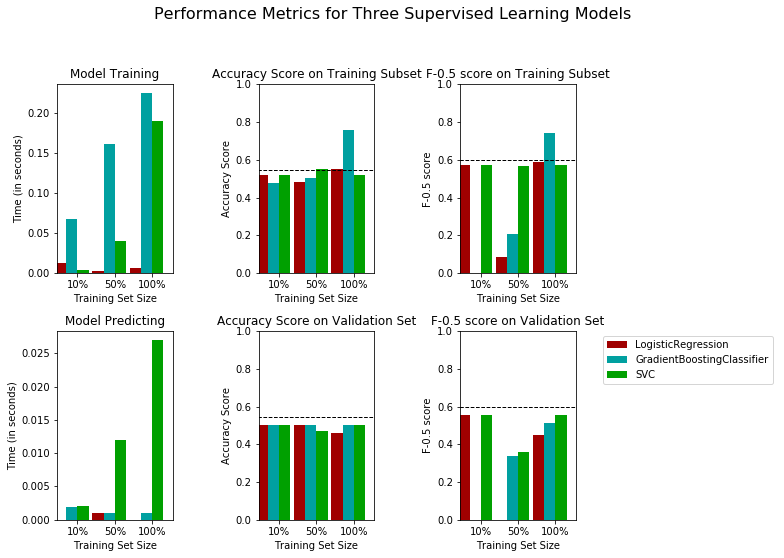

In [21]:
clf_A = LogisticRegression(random_state=0)
clf_B = GradientBoostingClassifier(random_state=0)
clf_C = SVC(random_state=0, gamma='auto')

samples_100 = len(y_train)
samples_50 = samples_100 // 2
samples_10 = samples_100 // 10

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_10, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_valid, y_valid)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)

Only Gradient Boosting classifier can beat the benchmark model on the training set. And the three supervised learning models cannot surpass the performance of benchmark model on accuracy and f-0.5 scores for the validation set. We will fine-tune the three models. 

## 6. Refinement

### 6.1 Refinement of SVM Classifier

We use GridSearch and 5-fold cross validation to find the optimal parameter settings.

In [22]:
clf = SVC(random_state=0)

parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5)

grid_fit = grid_obj.fit(X_train_valid, y_train_valid)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Optimized Model
------
Final accuracy score on the testing data: 0.5856
Final F-score on the testing data: 0.6385


We try to use 10-fold cross validation.

In [23]:
clf = SVC(random_state=0)

parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
               'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=10)

grid_fit = grid_obj.fit(X_train_valid, y_train_valid)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model on 10-fold CV\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Optimized Model on 10-fold CV
------
Final accuracy score on the testing data: 0.5856
Final F-score on the testing data: 0.6385


The performance of the models from 5-fold and 10-fold cross validation are the same. The optimal model of SVM has accuracy of 0.5856 and f-0.5 score of 0.6385 on the testing set.

### 6.2 Refinement of Logistic Regression Classifier

We use GridSearch and 5-fold cross validation to find the optimal parameter settings.

In [24]:
clf = LogisticRegression(random_state=0, solver='saga')

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
parameters = dict(C=C, penalty=penalty)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5)

grid_fit = grid_obj.fit(X_train_valid, y_train_valid)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Optimized Model
------
Final accuracy score on the testing data: 0.5901
Final F-score on the testing data: 0.6415


We try to use 10-fold cross validation.

In [25]:
clf = LogisticRegression(random_state=0, solver='saga')

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
parameters = dict(C=C, penalty=penalty)

grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=10)

grid_fit = grid_obj.fit(X_train_valid, y_train_valid)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Optimized Model
------
Final accuracy score on the testing data: 0.5856
Final F-score on the testing data: 0.6398


The optimal model of Logistic Regression has accuracy of 0.5901 and f-0.5 score of 0.6415 on the testing set.

### 6.3 Refinement of Gradient Boosting Classifier

We use GridSearch and 5-fold cross validation to find the optimal parameter settings.

In [26]:
clf = GradientBoostingClassifier(random_state=0)

parameters = {
    "loss":["exponential"],
    "min_samples_split": [3, 5],
    "min_samples_leaf": [3, 5],
    "n_estimators":[10, 15, 20, 30, 50]
    }

grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=5)

grid_fit = grid_obj.fit(X_train_valid, y_train_valid)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Optimized Model
------
Final accuracy score on the testing data: 0.6036
Final F-score on the testing data: 0.6538


We try to use 10-fold cross validation.

In [27]:
clf = GradientBoostingClassifier(random_state=0)

parameters = {
    "loss":["exponential"],
    "min_samples_split": [3, 5],
    "min_samples_leaf": [3, 5],
    "n_estimators":[10, 15, 20, 30, 50]
    }

grid_obj = GridSearchCV(clf, parameters, scoring=scorer, cv=10)

grid_fit = grid_obj.fit(X_train_valid, y_train_valid)

# Get the estimator
best_clf = grid_fit.best_estimator_

best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


Optimized Model
------
Final accuracy score on the testing data: 0.6126
Final F-score on the testing data: 0.6598


The optimal model of Gradient Boosting has accuracy of 0.6126 and f-0.5 score of 0.6598 on the testing set. And it is the best model among the three algorithms.

In [28]:
print(best_clf.get_params())

{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


The best Gradient Boosting model has minimum sample split of 3, minimum sample leaf of 5, and 10 estimators.

### 6.4 Comparison of Initial and Optimal Models of Gradient Boosting

We compare the initial and optimal models for Gradient Boosting on the testing set.

In [29]:
clf_initial = GradientBoostingClassifier(random_state=0)
clf_initial.fit(X_train, y_train)
initial_predictions = clf_initial.predict(X_test)

print("Accuracy score for the initial model: {:.4f}".format(accuracy_score(y_test, initial_predictions)))
print("F-0.5 score for the initial model: {:.4f}".format(fbeta_score(y_test, initial_predictions, beta = 0.5)))
print("Accuracy score for the optimal model: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-0.5 score for the optimal model: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Accuracy score for the initial model: 0.5946
F-0.5 score for the initial model: 0.6489
Accuracy score for the optimal model: 0.6126
F-0.5 score for the optimal model: 0.6598


## 7. Justification

Compare the performance of best Gradient Boosting model and benchmark model on the testing set.

In [30]:
accuracy = y_test.sum() / y_test.shape[0]
recall = 1
precision = y_test.sum() / y_test.shape[0]

fscore = (1 + 0.5**2) * precision * recall / ((0.5**2) * precision + recall)

print("Benchmark model on testing set: [Accuracy score: {:.4f}, F-0.5 score: {:.4f}]".format(accuracy, fscore))

gb_accuracy = accuracy_score(y_test, best_predictions)
gb_fscore = fbeta_score(y_test, best_predictions, beta = 0.5)

print("Best Gradient Boosting model on testing set: [Accuracy score: {:.4f}, F-0.5 score: {:.4f}]"\
      .format(gb_accuracy, gb_fscore))

Benchmark model on testing set: [Accuracy score: 0.5856, F-0.5 score: 0.6385]
Best Gradient Boosting model on testing set: [Accuracy score: 0.6126, F-0.5 score: 0.6598]


Since the accuracy and f-0.5 scores of the best Gradient Boosting model are better than that of the benchmark model, we can conclude that the ML model performs better than the benchmark model.